In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.optim as optim

from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Датасет для сегментации

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=14W5kgZbvR6P0YqaCE5X5jtffIQjuDiOg' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=14W5kgZbvR6P0YqaCE5X5jtffIQjuDiOg" -O new_images.zip && rm -rf /tmp/cookies.txt

--2020-06-13 08:29:16--  https://docs.google.com/uc?export=download&confirm=TaiW&id=14W5kgZbvR6P0YqaCE5X5jtffIQjuDiOg
Resolving docs.google.com (docs.google.com)... 74.125.200.100, 74.125.200.138, 74.125.200.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0o-docs.googleusercontent.com/docs/securesc/n411pmiduqmmtcd11u3073rs862n9u4m/3cc8ilfqhvu3a5j0037047i27ki19800/1592036925000/16592847221345603831/02024465461624494176Z/14W5kgZbvR6P0YqaCE5X5jtffIQjuDiOg?e=download [following]
--2020-06-13 08:29:16--  https://doc-0g-0o-docs.googleusercontent.com/docs/securesc/n411pmiduqmmtcd11u3073rs862n9u4m/3cc8ilfqhvu3a5j0037047i27ki19800/1592036925000/16592847221345603831/02024465461624494176Z/14W5kgZbvR6P0YqaCE5X5jtffIQjuDiOg?e=download
Resolving doc-0g-0o-docs.googleusercontent.com (doc-0g-0o-docs.googleusercontent.com)... 74.125.130.132, 2404:6800:4003:c01::84
Connecting

In [ ]:
!unzip new_images.zip

Streaming output truncated to the last 5000 lines.
 extracting: extracted_images/z/exp24869.jpg  
 extracting: extracted_images/z/exp24872.jpg  
 extracting: extracted_images/z/exp24893.jpg  
 extracting: extracted_images/z/exp24901.jpg  
 extracting: extracted_images/z/exp24916.jpg  
 extracting: extracted_images/z/exp24943.jpg  
 extracting: extracted_images/z/exp24946.jpg  
  inflating: extracted_images/z/exp25110.jpg  
  inflating: extracted_images/z/exp25118.jpg  
  inflating: extracted_images/z/exp25133.jpg  
 extracting: extracted_images/z/exp25161.jpg  
 extracting: extracted_images/z/exp25164.jpg  
 extracting: extracted_images/z/exp25172.jpg  
 extracting: extracted_images/z/exp25179.jpg  
  inflating: extracted_images/z/exp25193.jpg  
  inflating: extracted_images/z/exp25218.jpg  
 extracting: extracted_images/z/exp25221.jpg  
  inflating: extracted_images/z/exp25402.jpg  
  inflating: extracted_images/z/exp25403.jpg  
  inflating: extracted_images/z/exp25410.jpg  
 extracti

In [ ]:
!ls

drive  extracted_images  new_images.zip  sample_data


In [ ]:
!ls extracted_images/

'='   +   9	      div	      H        leq   phi	  sqrt	  y
 -    0   A	      e		      i        lim   pi		  sum	  z
 ,    1   alpha       exists	      in       log   pm		  T
'!'   2   ascii_124   f		      infty    lt    prime	  tan
'('   3   b	      forall	      int      M     q		  theta
')'   4   beta	      forward_slash   j        mu    R		  times
'['   5   C	      G		      k        N     rightarrow   u
 ]    6   cos	      gamma	      l        neq   S		  v
'{'   7   d	      geq	      lambda   o     sigma	  w
'}'   8   Delta       gt	      ldots    p     sin	  X


In [ ]:
image_transforms = {
    "train": transforms.Compose([
        #transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
#Второй способ: ImageFolder в качестве датасета и семплер

from torch.utils.data import SubsetRandomSampler
from torchvision.datasets import ImageFolder
img_dataset = ImageFolder(root='extracted_images', transform=image_transforms["train"])

#root_dir = "../../data/computer_vision/image_classification/natural-images/"

dataset_size = len(img_dataset)
dataset_indices = list(range(dataset_size))

np.random.shuffle(dataset_indices)
val_split_index = int(np.floor(0.2 * dataset_size))

train_idx, val_idx = dataset_indices[val_split_index:], dataset_indices[:val_split_index] 

train_sampler = SubsetRandomSampler(train_idx) 
val_sampler = SubsetRandomSampler(val_idx)

#даталоадеры
train_loader = DataLoader(dataset=img_dataset, shuffle=False, batch_size=1, sampler=train_sampler)
val_loader = DataLoader(dataset=img_dataset, shuffle=False, batch_size=1, sampler=val_sampler)

In [ ]:
def im_show(example):
    example1 = example.expand((1,3,45,45))
    example_np = example1.numpy().squeeze(0)
    example_np = example_np.transpose(1,2,0)
    plt.imshow(example_np)

torch.Size([1, 3, 45, 45])


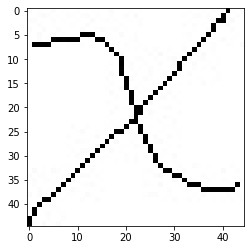

In [ ]:
example,label = next(iter(train_loader))
print(example.size())
im_show(example)

In [ ]:
train_loader = DataLoader(dataset=img_dataset, batch_size=128, shuffle=True)

Создаем сеть

In [ ]:
class Net(nn.Module):
    def __init__(self, in_features, hidden_size, num_classes):
        super().__init__()
        self.in_features = in_features
        self.layer1 = nn.Linear(in_features,hidden_size)
        self.layer2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()#нелинейная активация
    def forward(self,x):# размер данных на входе
        x = x.view(x.size(0), self.in_features)#меняем размер
        res1 = self.relu(self.layer1(x)) #после первого слоя
        out= F.softmax(self.layer2(res1)) #второй слой и софтмакс
        return out

In [ ]:
model = Net(6075,100,10).cuda()

Обучаем

In [ ]:
#optimizer = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(params=model.parameters(), lr=0.0001, betas=(0.9,0.999))
criterion = nn.CrossEntropyLoss()

In [ ]:
losses = []
num_epochs=30
model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda()

        model.zero_grad()
        pred = model(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epoch_losses.append(loss.item())
    print("Epoch [{}/{}], Loss: {}".format(epoch+1, num_epochs, sum(epoch_losses)/len(epoch_losses)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Epoch [1/30], Loss: 2.143539642865679
Epoch [2/30], Loss: 2.085239279383782
Epoch [3/30], Loss: 2.067042639825196
Epoch [4/30], Loss: 2.0538250675324763
Epoch [5/30], Loss: 2.0460702437296296
Epoch [6/30], Loss: 2.0335478628468886
Epoch [7/30], Loss: 2.017541172027263
Epoch [8/30], Loss: 2.014397832591003
Epoch [9/30], Loss: 2.0073895479157478
Epoch [10/30], Loss: 1.9952260531723458
Epoch [11/30], Loss: 1.9904923539246078
Epoch [12/30], Loss: 1.9861016357082992
Epoch [13/30], Loss: 1.9856184891407955
Epoch [14/30], Loss: 1.984849003361065
Epoch [15/30], Loss: 1.981942336278517
Epoch [16/30], Loss: 1.9815281913992984
Epoch [17/30], Loss: 1.9805969324868256
Epoch [18/30], Loss: 1.978777325015396
Epoch [19/30], Loss: 1.979590413722966
Epoch [20/30], Loss: 1.9775243046496336
Epoch [21/30], Loss: 1.9766983428400662
Epoch [22/30], Loss: 1.975686331116642
Epoch [23/30], Loss: 1.975492164381026
Epoch [24/30], Loss: 1.9751011654988204
Epoch [25/30], Loss: 1.9735792465888375
Epoch [26/30], Loss:

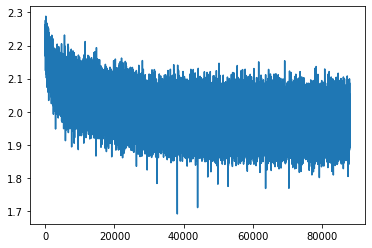

In [ ]:
plt.plot(losses)

In [ ]:
model.eval()
result = 0
for images, labels in val_loader:
    images = images.cuda()
    labels = labels.cuda()
    pred = model(images)
    prediction = torch.argmax(pred,1)
    res = torch.eq(prediction.cpu(),labels.cpu()).sum()
    result+=res.item()
print('Result: {}%'.format(result/dataset_size*100)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


Result: 7.191188752413731%


In [ ]:
test_loader = DataLoader(dataset=img_dataset, batch_size=5)
samples,labels = next(iter(test_loader))
samples_c = samples.cuda()
classes = ('=' , '+',   '9',	   'div',	      'H',    'leq',   'phi',	  'sqrt',	  'y',
 '-',    '0',   'A',	      'e',   'i',          'lim',      'pi',		  'sum',	  'z',
 ',',    '1',   'alpha',       'exists',	      'in',       'log',   'pm',		  'T',
'!',   '2',   'ascii_124',   'f',		      'infty',    'lt',    'prime',	  'tan',
'(',   '3',   'b',	      'forall',	      'int',      'M',     'q',		  'theta',
')',   '4',   'beta',	      'forward_slash',   'j',        'mu',    'R',		  'times',
'[',   '5',   'C',	      'G',		      'k',        'N',     'rightarrow',   'u',
 ']',    '6',   'cos',	      'gamma',	      'l',        'neq',   'S',		  'v',
'{',   '7',   'd',	      'geq',	      'lambda',   'o',     'sigma',	  'w',
'}',   '8',   'Delta',       'gt',	      'ldots',    'p',     'sin',	  'X')
pred = model(samples_c)
prediction = torch.argmax(pred, dim=1)
prediction = prediction.cpu().numpy().tolist()
samples = samples.cpu()
for i in range(len(prediction)):
    im_show(samples[i])
    print(classes[prediction[i]])
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


NameError: ignored